In [3]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Configurar rutas
DATA_PATH = Path('../data')
SAMPLE_PATH = DATA_PATH / 'nyc_taxi_sample.csv'
CLEAN_PATH = DATA_PATH / 'nyc_taxi_clean_reduced.csv'

print("📁 Rutas configuradas:")

📁 Rutas configuradas:


In [4]:
# Cargar datos
print("🔄 Cargando datos...")
df = pd.read_csv(SAMPLE_PATH)

# Mostrar información inicial
print("\n📊 Información del dataset original:")
print(f"Filas: {len(df):,}")
print(f"Columnas: {len(df.columns)}")
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Mostrar primeras filas
print("\n🔍 Primeras filas del dataset:")
print(df.head())

🔄 Cargando datos...

📊 Información del dataset original:
Filas: 1,458,644
Columnas: 11

Columnas disponibles:
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']

🔍 Primeras filas del dataset:
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1           -73.982           40.768            -73.965   
1                1           -73.980           40.739            -73.999   
2                1 

In [6]:
# Seleccionar solo las columnas necesarias
columnas_necesarias = [
    'pickup_datetime',    # Para features temporales
    'dropoff_datetime',   # Para calcular duración
    'passenger_count',    # Feature importante
    'pickup_longitude',   # Para calcular distancia
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
]

# Verificar columnas disponibles
columnas_disponibles = set(df.columns)
columnas_seleccionadas = set(columnas_necesarias)
columnas_faltantes = columnas_seleccionadas - columnas_disponibles

if columnas_faltantes:
    print(f"⚠️ Columnas faltantes: {columnas_faltantes}")
else:
    print("✅ Todas las columnas necesarias están disponibles")

# Seleccionar columnas
df_reducido = df[columnas_necesarias].copy()

print("\n📊 Dataset reducido:")
print(f"Filas: {len(df_reducido):,}")
print(f"Columnas: {len(df_reducido.columns)}")
print("\nColumnas seleccionadas:")
print(df_reducido.columns.tolist())

✅ Todas las columnas necesarias están disponibles

📊 Dataset reducido:
Filas: 1,458,644
Columnas: 7

Columnas seleccionadas:
['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


In [11]:
# Limpiar datos y crear features

# 1. Convertir fechas a datetime
print("🔄 Convirtiendo fechas...")
df_reducido['pickup_datetime'] = pd.to_datetime(df_reducido['pickup_datetime'])
df_reducido['dropoff_datetime'] = pd.to_datetime(df_reducido['dropoff_datetime'])

# 2. Calcular duración en minutos
df_reducido['duration_min'] = (df_reducido['dropoff_datetime'] - df_reducido['pickup_datetime']).dt.total_seconds() / 60

# 3. Extraer hora del día
df_reducido['hour'] = df_reducido['pickup_datetime'].dt.hour

# 4. Calcular distancia aproximada (usando la fórmula del haversine)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

df_reducido['distance_approx'] = haversine_distance(
    df_reducido['pickup_latitude'],
    df_reducido['pickup_longitude'],
    df_reducido['dropoff_latitude'],
    df_reducido['dropoff_longitude']
)

# 5. Eliminar outliers
print("\n🔍 Eliminando outliers...")

# Filtros razonables:
# - Duración entre 1 minuto y 2 horas
# - Distancia menor a 100 km
# - Al menos 1 pasajero
filtros = (
    (df_reducido['duration_min'] >= 1) &
    (df_reducido['duration_min'] <= 120) &
    (df_reducido['distance_approx'] <= 100) &
    (df_reducido['passenger_count'] >= 1)
)

df_limpio = df_reducido[filtros].copy()

# Mostrar estadísticas antes y después
print(f"\nRegistros originales: {len(df_reducido):,}")
print(f"Registros después de filtrar: {len(df_limpio):,}")
print(f"Registros eliminados: {len(df_reducido) - len(df_limpio):,}")

# Mostrar estadísticas básicas
print("\n📊 Estadísticas del dataset limpio:")
print(df_limpio.describe())

🔄 Convirtiendo fechas...

🔍 Eliminando outliers...

🔍 Eliminando outliers...

Registros originales: 1,458,644
Registros después de filtrar: 1,447,763
Registros eliminados: 10,881

📊 Estadísticas del dataset limpio:

Registros originales: 1,458,644
Registros después de filtrar: 1,447,763
Registros eliminados: 10,881

📊 Estadísticas del dataset limpio:
                     pickup_datetime               dropoff_datetime  \
count                        1447763                        1447763   
mean   2016-04-01 09:54:40.843120896  2016-04-01 10:08:41.704186624   
min              2016-01-01 00:00:17            2016-01-01 00:03:31   
25%       2016-02-17 16:28:08.500000            2016-02-17 16:42:10   
50%              2016-04-01 16:47:24            2016-04-01 17:06:15   
75%              2016-05-15 03:33:19            2016-05-15 03:44:42   
max              2016-06-30 23:59:39            2016-07-01 00:48:20   
std                              NaN                            NaN   

       

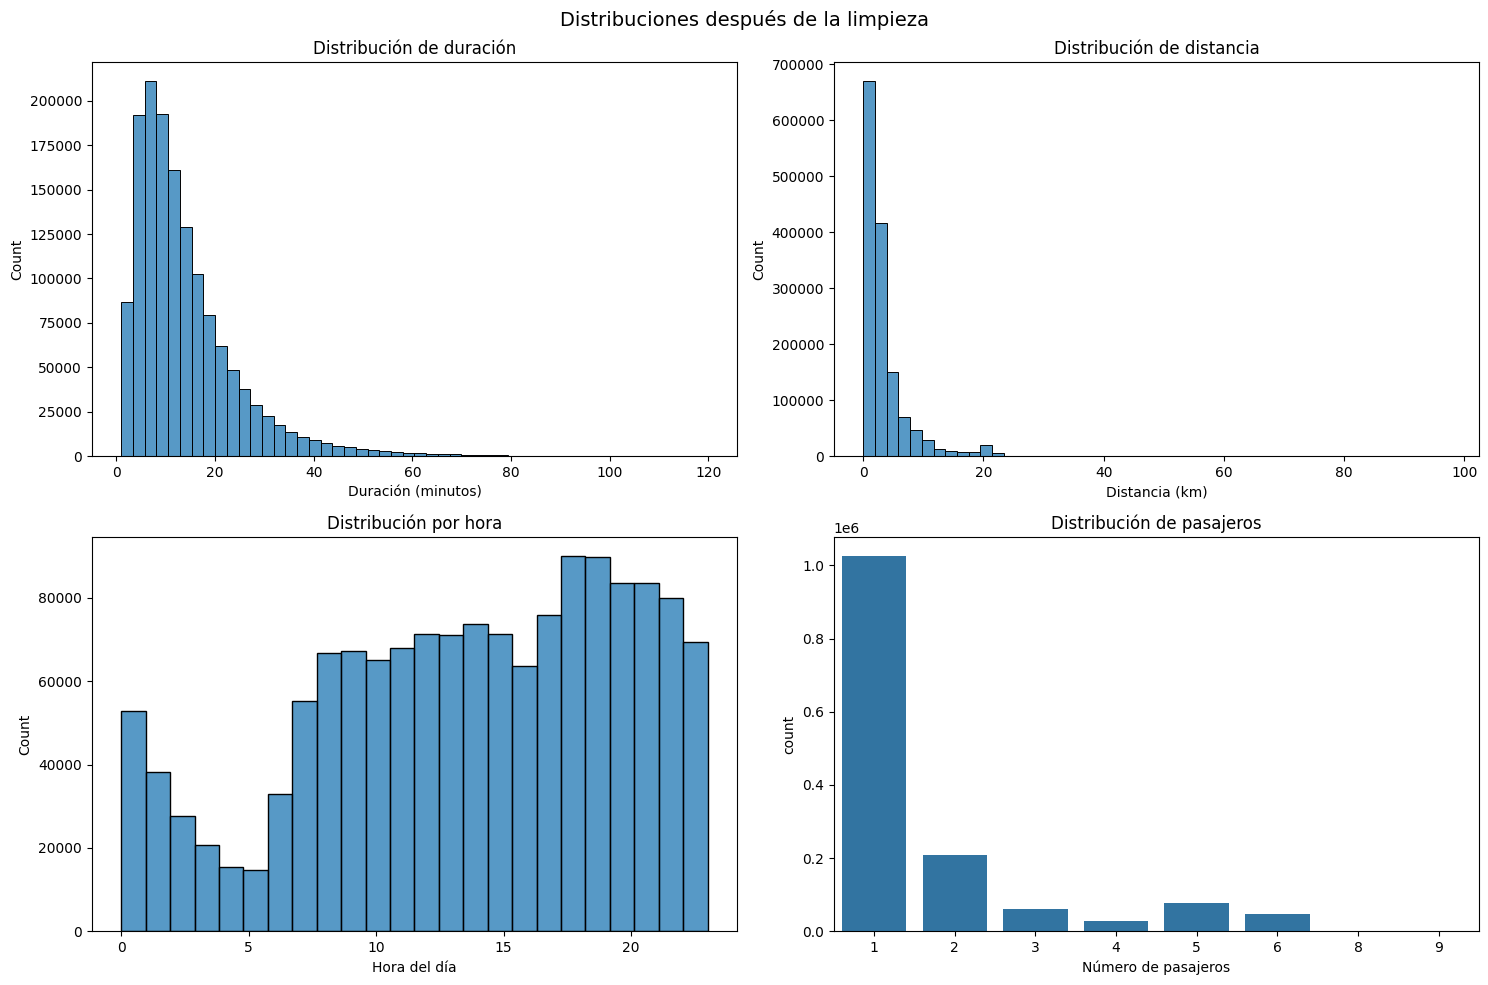

In [12]:
# Visualizar distribuciones para verificar la limpieza

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribuciones después de la limpieza', fontsize=14)

# Duración
sns.histplot(data=df_limpio, x='duration_min', bins=50, ax=axes[0,0])
axes[0,0].set_title('Distribución de duración')
axes[0,0].set_xlabel('Duración (minutos)')

# Distancia
sns.histplot(data=df_limpio, x='distance_approx', bins=50, ax=axes[0,1])
axes[0,1].set_title('Distribución de distancia')
axes[0,1].set_xlabel('Distancia (km)')

# Hora
sns.histplot(data=df_limpio, x='hour', bins=24, ax=axes[1,0])
axes[1,0].set_title('Distribución por hora')
axes[1,0].set_xlabel('Hora del día')

# Pasajeros
sns.countplot(data=df_limpio, x='passenger_count', ax=axes[1,1])
axes[1,1].set_title('Distribución de pasajeros')
axes[1,1].set_xlabel('Número de pasajeros')

plt.tight_layout()
plt.show()

In [13]:
# Guardar dataset limpio
print("💾 Guardando dataset limpio...")

# Seleccionar columnas finales (eliminar coordenadas ya que tenemos distancia)
columnas_finales = [
    'pickup_datetime',
    'hour',
    'passenger_count',
    'distance_approx',
    'duration_min'
]

df_final = df_limpio[columnas_finales].copy()

# Ordenar por fecha
df_final = df_final.sort_values('pickup_datetime')

# Guardar
df_final.to_csv(CLEAN_PATH, index=False)
print(f"✅ Dataset limpio guardado en: {CLEAN_PATH}")

# Mostrar información final
print(f"\n📊 Dataset final:")
print(f"Filas: {len(df_final):,}")
print(f"Columnas: {len(df_final.columns)}")
print("\nColumnas finales:")
print(df_final.columns.tolist())
print("\nPrimeras filas del dataset final:")
print(df_final.head())

💾 Guardando dataset limpio...
✅ Dataset limpio guardado en: ..\data\nyc_taxi_clean_reduced.csv

📊 Dataset final:
Filas: 1,447,763
Columnas: 5

Columnas finales:
['pickup_datetime', 'hour', 'passenger_count', 'distance_approx', 'duration_min']

Primeras filas del dataset final:
           pickup_datetime  hour  passenger_count  distance_approx  \
96469  2016-01-01 00:00:17     0                5           12.757   
223872 2016-01-01 00:00:53     0                1            4.010   
713067 2016-01-01 00:01:01     0                5            2.171   
652463 2016-01-01 00:01:14     0                1            0.770   
722901 2016-01-01 00:01:20     0                1            2.475   

        duration_min  
96469         14.150  
223872        21.567  
713067         6.800  
652463         4.667  
722901        12.267  
✅ Dataset limpio guardado en: ..\data\nyc_taxi_clean_reduced.csv

📊 Dataset final:
Filas: 1,447,763
Columnas: 5

Columnas finales:
['pickup_datetime', 'hour', 'pas